In [1]:
from _tests import scripts
from scripts.notebook_utils import *


In [2]:
def run_layer(dnn: str, layer: str):
    print(f"{layer} ", end="", flush=True)
    spec = get_spec(
        "cascade",
        # Weight-stationary, dummy buffer on top to hold inputs & outputs, many
        # macros to ensure we can fit all weights.
        system="cascade_dummy_buffer_many_macro",
        # Set the DNN and layer
        dnn=dnn,
        layer=layer,
    )
    

    # Do NOT generate a maximum-utilization workload; we're running a DNN
    # workload.
    spec.variables["MAX_UTILIZATION"] = False

    spec.architecture.find("column").spatial.meshX = 64
    spec.architecture.find("row").spatial.meshY = 64
    spec.architecture.find("buffer_rram").attributes.depth = 32
    spec.architecture.find("buffer_rram").attributes.width = 32
    # display_diagram(spec.to_diagram(["macro", "cim_array", "column", "row"]))
    factors = spec.architecture.find("adc").constraints.temporal.factors_only
    # factors.add_eq_factor("X", 16, overwrite=True)
    # factors_2 = spec.architecture.find("buffer_rram").constraints.temporal.factors_only
    # factors_2.add_eq_factor("X", 4, overwrite=True)

    
    return run_mapper(spec)


DNN_OPTIONS = [
    d
    for d in os.listdir(f"../../../workloads/")
    if os.path.isdir(f"../../../workloads/{d}")
]
DNN_OPTIONS = [d for d in DNN_OPTIONS if not d.startswith("_")]
print(f"Available DNNs: {DNN_OPTIONS}")

# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================
DNN = "alexnet"
# =============================================================================
# Change this DNN to explore different DNNs!
# =============================================================================

layers_2 = [f for f in os.listdir(f"../../../workloads/{DNN}") if f != "index.yaml" and f.endswith(".yaml")]
layers_2 = sorted(layers_2)
real_layers_2 = layers_2
print(f"Running: ", end="")

results_2 = joblib.Parallel(n_jobs=None)(
    joblib.delayed(run_layer)(DNN, layer.split(".")[0]) for layer in real_layers_2
)
print("")

Available DNNs: ['gpt2_medium', 'vgg16', 'mobilenet_v3', 'msft_phi_1_5', 'alexnet', 'mobilebert', 'vision_transformer', 'densenet201', 'resnet18', 'dpt_large']
Running: 0 1 2 3 4 5 6 7 


total energy 0.0001560079429463081
193600000000.0
384000000000.0
460800000000.0
307200000000.0
409600000000.0
409600000000.0
409600000000.0
512000000000.0
avg throughput 385800000000.0
{'CiM': 1.2509593600000002e-13, 'Accumulation': 1.2620607999999999e-14, 'ADC': 7.000224e-14}
{'CiM': 60.223699364617886, 'Accumulation': 6.075814501205628, 'ADC': 33.70048613417648}


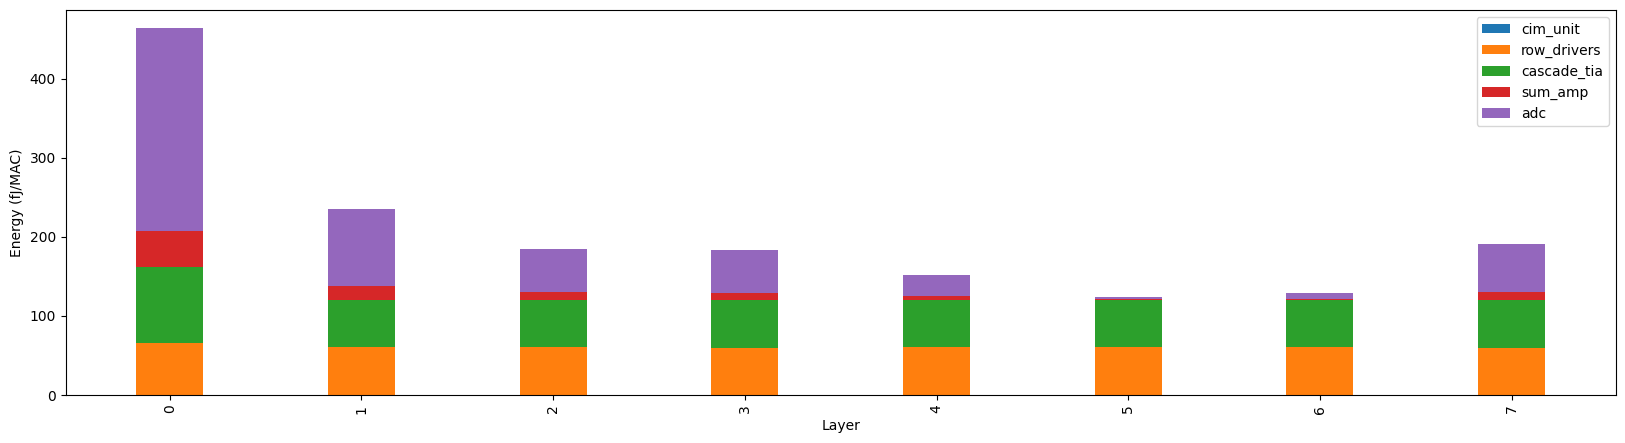

In [7]:
import copy

results_copy = copy.deepcopy(results_2)
total_energy = 0
for r in results_copy:
    total_energy += r.energy

print("total energy", total_energy)

per_computer_dict = {}
total_throughput = 0
num_layers = 0
for r in results_copy:
    r.clear_zero_energies()
    num_layers += 1
    per_compute_dict = r.per_compute("per_component_energy")
    total_throughput += r.computes_per_second
    print(r.computes_per_second)
avg_throughput = total_throughput/num_layers
print("avg throughput", avg_throughput)
# print(per_compute_dict)


total_per_compute = {'CiM': 0, 'Accumulation': 0, 'ADC': 0}
for r in results_copy:
    per_compute = r.per_compute("per_component_energy")
    total_per_compute['CiM'] += per_compute['cim_unit']
    total_per_compute['CiM'] += per_compute['row_drivers']
    total_per_compute['CiM'] += per_compute['cascade_tia']
    total_per_compute['Accumulation'] += per_compute['sum_amp']
    total_per_compute['ADC'] += per_compute['adc']

for k in total_per_compute:
    total_per_compute[k] = total_per_compute[k]/num_layers

print(total_per_compute)

percent_breakdown = {}
total_compute = 0
for k in total_per_compute:
    total_compute += total_per_compute[k]
percent_breakdown['CiM'] = (total_per_compute["CiM"]/total_compute) * 100
percent_breakdown['Accumulation'] = (total_per_compute["Accumulation"]/total_compute) * 100
percent_breakdown['ADC'] = (total_per_compute["ADC"]/total_compute) * 100
print(percent_breakdown)

# Display an energy breakdown for each layer as a bar chart. Display normalized per-MAC and per-layer energy.
fig, ax = plt.subplots(figsize=(20, 5))

bar_stacked(
    {i: r.per_compute("per_component_energy") * 1e15 for i, r in enumerate(results_copy)},
    title="",
    xlabel="Layer",
    ylabel="Energy (fJ/MAC)",
    ax=ax,
)

In [135]:
highest_energy_result = max(results, key=lambda x: x.per_compute("energy"))
print(f"Mapping:\n{highest_energy_result.mapping}")

Mapping:
dummy_top [ Inputs:334176 (334176) Outputs:4014080 (4014080) ] 
--------------------------------------------------------------
| for P in [0:112)
|   for Q in [0:28)

inter_macro_in_system_spatial [ ] 
---------------------------------
|     for S in [0:3) (Spatial-X)

adc [ Outputs:1280 (1280) ] 
column_drivers [ Outputs:1280 (1280) ] 
sum_amp [ Outputs:1280 (1280) ] 
buffer_rram [ Outputs:1280 (1280) ] 
-----------------------------------
|       for Q in [0:4)

cascade_tia [ Outputs:320 (320) ] 
row_drivers [ Inputs:504 (504) ] 
inter_column_spatial [ ] 
------------------------
|         for M in [0:64) (Spatial-X)

inter_row_spatial [ ] 
---------------------
|           for S in [0:3,1) (Spatial-Y)
|             for R in [0:7) (Spatial-Y)
|               for C in [0:3) (Spatial-Y)

cim_unit [ Weights:8 (8) ] 
inter_1bit_x_1bit_mac_spatial [ ] 
---------------------------------
|                 for Z in [0:5) (Spatial-X)
|                   for Y in [0:8) (Spatial-X)
|  